In [1]:
from imp import reload
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
# Use Type 1 fonts in plots.
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = False
# Do not wrap long lines
np.set_printoptions(linewidth=np.nan)
sns.set_style("whitegrid")
import runner
import umm
import mallows_hamming as mh

In [2]:
# instance synthetic, the best sol is
n = 20
flow = np.random.random((n,n))
for i in range(n):
    for j in range(n):
        if i==j: flow[i,i]=0
        else: flow[i,j] += 1/(abs(i-j))
for i in range(n):
    for j in range(n):
#         print(round(flow[i,j],4), " ", end="")
        print(round((abs(i-j)),4), " ", end="") #distance between locations
    print()

0  1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  16  17  18  19  
1  0  1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  16  17  18  
2  1  0  1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  16  17  
3  2  1  0  1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  16  
4  3  2  1  0  1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  
5  4  3  2  1  0  1  2  3  4  5  6  7  8  9  10  11  12  13  14  
6  5  4  3  2  1  0  1  2  3  4  5  6  7  8  9  10  11  12  13  
7  6  5  4  3  2  1  0  1  2  3  4  5  6  7  8  9  10  11  12  
8  7  6  5  4  3  2  1  0  1  2  3  4  5  6  7  8  9  10  11  
9  8  7  6  5  4  3  2  1  0  1  2  3  4  5  6  7  8  9  10  
10  9  8  7  6  5  4  3  2  1  0  1  2  3  4  5  6  7  8  9  
11  10  9  8  7  6  5  4  3  2  1  0  1  2  3  4  5  6  7  8  
12  11  10  9  8  7  6  5  4  3  2  1  0  1  2  3  4  5  6  7  
13  12  11  10  9  8  7  6  5  4  3  2  1  0  1  2  3  4  5  6  
14  13  12  11  10  9  8  7  6  5  4  3  2  1  0  1  2  3  4  5  
15  14  13  12 

## Running UMM and CEGO over one instance

The next cell allows running CEGO and UMM over a chosen instance and with the selected parameters

In [65]:
reload(runner)
# instance_name="LOP-synthetic,seed=123456,n=20,m=200,phi=0.5"
instance_name = "pfsp_csum/tai20_5_3.fsp"
# instance_name="pfsp_csum/rec19.txt"
# instance_name="lop/RandB/N-p50-01"
# instance_name="lop/Spec/N-pal13"
# instance_name="lop/xLOLIB/N-be75eec_150"
# instance_name="qap/nug12.dat"
# instance_name="qap/test.dat"
budgetGA=10**3#
seed=8
budget=100
m_ini=10
budgetMM=1## NO TOCAR
eval_ranks = False
r_1 = [.1]
r_2 = [.9]
res = []
for ratio_samples_learn in r_1:
  for weight_mass_learn in r_2:
    out_filename = "pickles/"+instance_name.replace("/", "_").replace(".txt", "")#+'_Budget_'+str(budgetMM)
    df = runner.run_once("UMM", instance_name, seed,budget = budget, m_ini = m_ini, budgetMM = budgetMM, ratio_samples_learn = ratio_samples_learn, weight_mass_learn = weight_mass_learn, out_filename = out_filename, eval_ranks=eval_ranks,init='random')
#     res.append([out_filename,ratio_samples_learn, weight_mass_learn,df.Fitness.min()])
# runner.run_once("CEGO", instance_name, seed,budget = budget, m_ini = m_ini, budgetGA = budgetGA, out_filename = out_filename)

Reading instance from pfsp_csum/tai20_5_3.fsp
header: number of jobs, number of machines, initial seed, upper bound and lower bound :



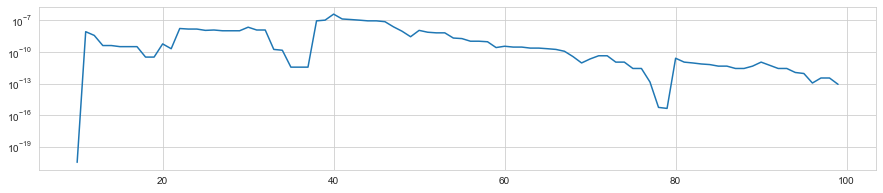

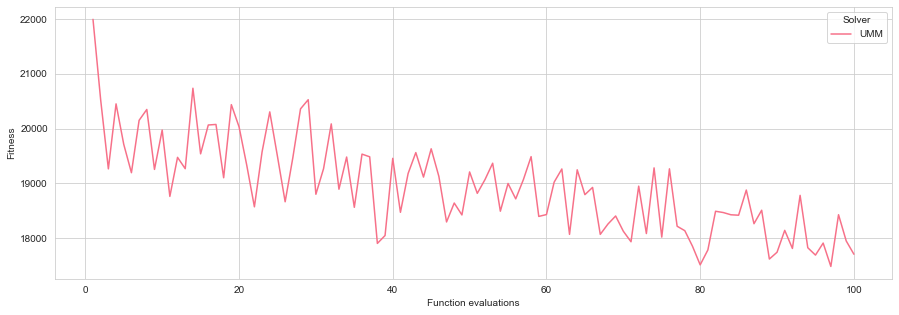

In [66]:
df = pd.read_csv(out_filename+ '.csv.xz')
df
plt.figure(figsize=(15,3))
df.rho.plot(logy=True)
plt.show()
# df.rho.plot(logy=False)
# print("instance name", df.instance.iloc[0], "- time", round(df.run_time.iloc[0], 2))
# print(df.Fitness.min())

color_variable = 'Solver'
y_variables = ['Fitness']#,'Distance','phi_sample'
palette = sns.color_palette("husl", len(df[color_variable].drop_duplicates()))
for y_variable in y_variables:
    plt.figure(figsize=(15,5))
    sns.lineplot(x='Function evaluations',y=y_variable,hue='Solver',data=df, palette=palette)
#     plt.savefig('img/'+instance_name.replace("/", "__").replace(".txt", "")+'order.eps')
    plt.show()

- TFT pfsp_csum/tai20_5_8.fsp.txt"

    - budget=1000  -> 60k

    - budget=5000  -> 60k

    - best sols TFT https://www.researchgate.net/figure/Best-known-solutions-for-Taillards-benchmarks-with-respect-to-total-flowtime-criterion_tbl8_223094938
  
- makespan  pfsp_cmax/tai20_5_8.fsp.txt"

    - best sols makespan https://www.researchgate.net/publication/269820959_Handling_ties_in_heuristics_for_the_permutation_flow_shop_scheduling_problem/link/5e31680ba6fdccd9657373fd/download